Fake News Detection

In [1]:
import os
import pyspark
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase'
# , '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/22 13:39:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/poojaakki/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
import pandas as pd
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType

schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])

df0 = pd.read_csv('Fake.csv')
df1 = pd.read_csv('True.csv')
df_fake = spark.createDataFrame(df0,schema=schema)
df_true = spark.createDataFrame(df1,schema=schema)

In [3]:
# Display fake news

df_fake.show()

22/12/22 13:39:27 WARN TaskSetManager: Stage 0 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [4]:
# Display fake news

df_true.show()

22/12/22 13:39:28 WARN TaskSetManager: Stage 1 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/22 13:39:32 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|politicsNews|December 29, 2017 |
|Trump on Twitter ...|The foll

In [5]:
# add a label to the data for fake news as 0 and true news as 1 and shuffle using rand
from pyspark.sql.functions import lit, rand

df= df_true.withColumn('flag', lit(1)).union(df_fake.withColumn('flag', lit(0))).orderBy(rand())

In [6]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)



In [7]:
df.show()

22/12/22 13:39:32 WARN TaskSetManager: Stage 2 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+--------------------+---------------+-------------------+----+
|               title|                text|        subject|               date|flag|
+--------------------+--------------------+---------------+-------------------+----+
|U.S. Labor Dept n...|WASHINGTON (Reute...|   politicsNews| February 15, 2017 |   1|
| Fox Host: Don’t ...|Fox News host Tuc...|           News|      June 19, 2016|   0|
|Amnesty Internati...|CAIRO (Reuters) -...|      worldnews|September 12, 2017 |   1|
|Civil liberties g...|BOSTON (Reuters) ...|   politicsNews|    April 12, 2017 |   1|
|China tells Austr...|BEIJING (Reuters)...|      worldnews| December 15, 2017 |   1|
|LOL! $45 MILLION ...|She s pulling dow...|      left-news|        Jan 9, 2017|   0|
|JUST IN: Obama Re...|This could be one...|       politics|       Dec 18, 2017|   0|
|Senators

#Graph Analysis

22/12/22 13:39:33 WARN TaskSetManager: Stage 3 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='date'>

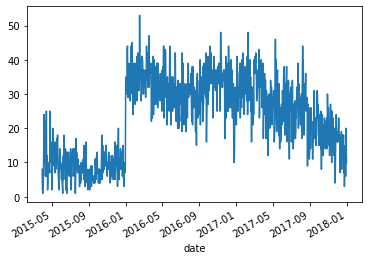

In [8]:
# number of fake and true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_fake.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


22/12/22 13:39:35 WARN TaskSetManager: Stage 4 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='date'>

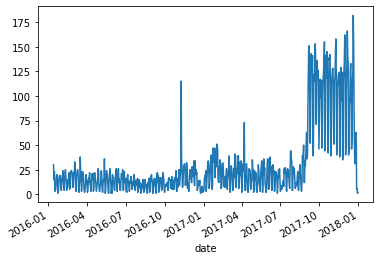

In [9]:
# number of true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_true.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


In [10]:
#types of news and highest number of news in order fromt he dataset
from pyspark.sql.functions import col

df.groupby('subject').count().sort(col("count").desc())

22/12/22 13:39:37 WARN TaskSetManager: Stage 5 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:37 WARN TaskSetManager: Stage 8 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


22/12/22 13:39:38 WARN TaskSetManager: Stage 11 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:38 WARN TaskSetManager: Stage 12 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:title={'center':'Articles per subject'}, ylabel='title'>

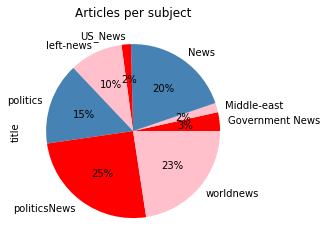

In [11]:
# Pie chart with counts of various news subjects Political and world news contained the highest counts .
from matplotlib import pyplot as plt

df1 = df

df1 = df1.toPandas()

colors = ['pink', 'silver', 'steelblue']

df1.groupby(['subject'])['title'].count().plot(kind='pie', y='count', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Articles per subject')


In [12]:
# type of article which have fake news

df1_fake = df_fake

df1_fake.groupby(['subject']).count()

22/12/22 13:39:39 WARN TaskSetManager: Stage 15 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:39 WARN TaskSetManager: Stage 18 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


subject,count
News,9050
politics,6841
Government News,1570
left-news,4459
US_News,783
Middle-east,778


In [13]:
# type of article which have true news

df1_true = df_true

df1_true.groupby(['subject']).count()

22/12/22 13:39:40 WARN TaskSetManager: Stage 21 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:40 WARN TaskSetManager: Stage 24 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145


In [14]:
# text pre-processing

from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('title',(lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')), 'subject', 'date', 'flag')

In [15]:
# tokenize the text

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='text', outputCol='words_token')

df = tokenizer.transform(df).select('title','words_token','subject','date','flag')

In [16]:
df.first()

22/12/22 13:39:45 WARN TaskSetManager: Stage 27 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='U.S. Labor Dept nominee Puzder withdraws, in blow to Trump', words_token=['washington', 'reuters', '', 'in', 'a', 'blow', 'to', 'president', 'donald', 'trump', 'as', 'he', 'tries', 'to', 'assemble', 'his', 'administration', 'his', 'nominee', 'for', 'labor', 'secretary', 'andrew', 'puzder', 'withdrew', 'his', 'name', 'from', 'consideration', 'on', 'wednesday', 'amid', 'concerns', 'that', 'he', 'could', 'not', 'garner', 'enough', 'senate', 'votes', 'to', 'be', 'confirmed', 'puzders', 'decision', 'to', 'withdraw', 'is', 'yet', 'another', 'setback', 'this', 'week', 'for', 'a', 'white', 'house', 'still', 'grappling', 'with', 'fallout', 'from', 'monday', 'nights', 'abrupt', 'resignation', 'of', 'national', 'security', 'adviser', 'michael', 'flynn', 'after', 'less', 'than', 'a', 'month', 'in', 'the', 'job', 'puzder', 'the', 'chief', 'executive', 'officer', 'of', 'cke', 'restaurants', 'inc', 'which', 'franchises', 'fastfood', 'chains', 'including', 'hardees', 'and', 'carls', 'jr', '

In [17]:
#remove empty string from the frame
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [18]:
df.first()

22/12/22 13:39:47 WARN TaskSetManager: Stage 28 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:48 WARN TaskSetManager: Stage 29 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='U.S. Labor Dept nominee Puzder withdraws, in blow to Trump', words_token=['washington', 'reuters', 'in', 'a', 'blow', 'to', 'president', 'donald', 'trump', 'as', 'he', 'tries', 'to', 'assemble', 'his', 'administration', 'his', 'nominee', 'for', 'labor', 'secretary', 'andrew', 'puzder', 'withdrew', 'his', 'name', 'from', 'consideration', 'on', 'wednesday', 'amid', 'concerns', 'that', 'he', 'could', 'not', 'garner', 'enough', 'senate', 'votes', 'to', 'be', 'confirmed', 'puzders', 'decision', 'to', 'withdraw', 'is', 'yet', 'another', 'setback', 'this', 'week', 'for', 'a', 'white', 'house', 'still', 'grappling', 'with', 'fallout', 'from', 'monday', 'nights', 'abrupt', 'resignation', 'of', 'national', 'security', 'adviser', 'michael', 'flynn', 'after', 'less', 'than', 'a', 'month', 'in', 'the', 'job', 'puzder', 'the', 'chief', 'executive', 'officer', 'of', 'cke', 'restaurants', 'inc', 'which', 'franchises', 'fastfood', 'chains', 'including', 'hardees', 'and', 'carls', 'jr', 'has'

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poojaakki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [21]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [22]:
df = pipelineFitRemoveStopWords.transform(df) #added here

In [23]:
df.first()

22/12/22 13:39:54 WARN TaskSetManager: Stage 32 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:55 WARN TaskSetManager: Stage 33 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='U.S. Labor Dept nominee Puzder withdraws, in blow to Trump', words_token=['washington', 'reuters', 'in', 'a', 'blow', 'to', 'president', 'donald', 'trump', 'as', 'he', 'tries', 'to', 'assemble', 'his', 'administration', 'his', 'nominee', 'for', 'labor', 'secretary', 'andrew', 'puzder', 'withdrew', 'his', 'name', 'from', 'consideration', 'on', 'wednesday', 'amid', 'concerns', 'that', 'he', 'could', 'not', 'garner', 'enough', 'senate', 'votes', 'to', 'be', 'confirmed', 'puzders', 'decision', 'to', 'withdraw', 'is', 'yet', 'another', 'setback', 'this', 'week', 'for', 'a', 'white', 'house', 'still', 'grappling', 'with', 'fallout', 'from', 'monday', 'nights', 'abrupt', 'resignation', 'of', 'national', 'security', 'adviser', 'michael', 'flynn', 'after', 'less', 'than', 'a', 'month', 'in', 'the', 'job', 'puzder', 'the', 'chief', 'executive', 'officer', 'of', 'cke', 'restaurants', 'inc', 'which', 'franchises', 'fastfood', 'chains', 'including', 'hardees', 'and', 'carls', 'jr', 'has'

In [24]:
# most freq words in data

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

df_freq.show(5)

22/12/22 13:39:55 WARN TaskSetManager: Stage 36 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:39:56 WARN TaskSetManager: Stage 37 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+--------------------+------------+-------------------+----+--------------------+
|               title|         words_token|     subject|               date|flag|                text|
+--------------------+--------------------+------------+-------------------+----+--------------------+
|U.S. Labor Dept n...|[washington, reut...|politicsNews| February 15, 2017 |   1|washington reuter...|
| Fox Host: Don’t ...|[fox, news, host,...|        News|      June 19, 2016|   0|fox news host tuc...|
|Amnesty Internati...|[cairo, reuters, ...|   worldnews|September 12, 2017 |   1|cairo reuters amn...|
|Civil liberties g...|[boston, reuters,...|politicsNews|    April 12, 2017 |   1|boston reuters ci

In [25]:
# most frequent fake words

df_fake_freq = df_freq.filter(df["flag"] == 0)

df_fake_text = df_fake_freq.select("text")


In [26]:
from pyspark.sql.functions import explode

df_fake_text = df_fake_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_fake = df_fake_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_fake.orderBy(col("count").desc()).show()

22/12/22 13:39:58 WARN TaskSetManager: Stage 40 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/22 13:40:02 WARN TaskSetManager: Stage 41 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|     word|count|
+---------+-----+
|    trump|73933|
|     said|31013|
|   people|25963|
|president|25586|
|    would|23427|
|      one|22935|
|       us|22049|
|  clinton|18011|
|    obama|17813|
|     like|17621|
|   donald|17215|
|     also|15242|
|      new|14158|
|     news|14126|
|     even|13717|
|  hillary|13565|
|    white|12778|
|     time|12728|
|    state|12525|
|      via|11273|
+---------+-----+
only showing top 20 rows



In [27]:
#most true words

df_true_freq = df_freq.filter(df["flag"] == 1)

df_true_text = df_true_freq.select("text")

In [28]:
from pyspark.sql.functions import explode

df_true_text = df_true_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_true = df_true_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_true.orderBy(col("count").desc()).show()

22/12/22 13:40:07 WARN TaskSetManager: Stage 47 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/22 13:40:09 WARN TaskSetManager: Stage 48 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|      word|count|
+----------+-----+
|      said|98985|
|     trump|42577|
|        us|41137|
|     would|31514|
|   reuters|28306|
| president|25533|
|     state|18753|
|government|17976|
|    states|17634|
|       new|16785|
|     house|16405|
|      also|15944|
|    united|15572|
|republican|15288|
|    people|15111|
|      told|14242|
|     could|13697|
|       one|12674|
|      last|12613|
|washington|12140|
+----------+-----+
only showing top 20 rows



In [29]:
df_freq.printSchema()

root
 |-- title: string (nullable = true)
 |-- words_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [30]:
df_freq.count()

22/12/22 13:40:14 WARN TaskSetManager: Stage 54 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


44898

In [31]:
# drop unwanted coloumns

df_ml = df_freq.drop("title","words_token","date")
df_ml.printSchema()

root
 |-- subject: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [32]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_ml.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show()

22/12/22 13:40:15 WARN TaskSetManager: Stage 57 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:40:15 WARN TaskSetManager: Stage 58 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+---------------+----+--------------------+---+
|        subject|flag|                text| id|
+---------------+----+--------------------+---+
|   politicsNews|   1|washington reuter...|  0|
|           News|   0|fox news host tuc...|  1|
|      worldnews|   1|cairo reuters amn...|  2|
|   politicsNews|   1|boston reuters ci...|  3|
|      worldnews|   1|beijing reuters c...|  4|
|      left-news|   0|pulling cool mill...|  5|
|       politics|   0|could one largest...|  6|
|   politicsNews|   1|washington reuter...|  7|
|        US_News|   0|prof michel choss...|  8|
|      worldnews|   1|berlin reuters ch...|  9|
|   politicsNews|   1|washington reuter...| 10|
|       politics|   0|dr abdul elsayed ...| 11|
|       politics|   0|               watch| 12|
|           News|   0|seth meyers destr...| 13|
|        US_News|   0|st century wire s...| 14|
|Government News|   0|sad tragic misund...| 15|
|       politics|   0|seen escalation v...| 16|
|       politics|   0|believe passes of.

In [33]:
# x values and Y values

x = df_ml.select('text').rdd.flatMap(lambda x: x).collect()
y = df_ml.select('flag').rdd.flatMap(lambda x: x).collect()

22/12/22 13:40:16 WARN TaskSetManager: Stage 61 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:40:16 WARN TaskSetManager: Stage 62 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/22 13:40:21 WARN TaskSetManager: Stage 65 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/22 13:40:21 WARN TaskSetManager: Stage 66 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25)

In [35]:
print(x_train[0])
print(y_train[0])

athens reuters greek police said arrested year old syrian man suspected involvement terrorist acts abroad man arrested thursday northern city alexandroupolis expected appear state prosecutor friday police said statement man requested asylum northern greece police official said arrested violating restriction order imposed wife accused participating terrorist acts investigating participation extent past terrorist acts outside greece police said authorities also examining photographs found mobile phone police source said
1


In [36]:
#vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [38]:
xv_train

<33673x184500 sparse matrix of type '<class 'numpy.float64'>'
	with 5441418 stored elements in Compressed Sparse Row format>

In [39]:
xv_train.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [42]:
LR.score(xv_test, y_test)

0.9896659242761693

In [43]:
pred_LR = LR.predict(xv_test)

In [44]:
classification_report(y_test, pred_LR)

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      5882\n           1       0.99      0.99      0.99      5343\n\n    accuracy                           0.99     11225\n   macro avg       0.99      0.99      0.99     11225\nweighted avg       0.99      0.99      0.99     11225\n'

In [45]:
import re, string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [46]:
import pandas as pd
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \n".format(output_lable(pred_LR[0])))

In [48]:
news = str(input())
manual_testing(news)

 Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev



LR Prediction: Fake News 



#Flagging Twitter Data

In [49]:
schema= StructType(
      [StructField('UserName',StringType(),True),
      StructField('Tweet ID',StringType(),True),
      StructField('Date',StringType(),True),
      StructField('Tweet_Text',StringType(),True)])
df = pd.read_csv('tweets.csv')
df = spark.createDataFrame(df,schema = schema)

In [50]:
df.show()

+---------------+-------------------+--------------------+--------------------+
|       UserName|           Tweet ID|                Date|          Tweet_Text|
+---------------+-------------------+--------------------+--------------------+
|robertaisbtlrdy|1605352339480649729|2022-12-20 23:59:...|RT @MariaBartirom...|
| PurpRmPolitics|1605352288507281409|2022-12-20 23:59:...|Full story https:...|
|   DailyPattaya|1605352287219732480|2022-12-20 23:59:...|The latest The Pa...|
|    basimtrades|1605352262754148352|2022-12-20 23:59:...|RT @BetterLunc: ?...|
|   hatomasu0704|1605352123222609921|2022-12-20 23:59:...|RT @NEWS_4_KMSY: ...|
|       railpage|1605352119502262273|2022-12-20 23:59:...|Boost for Wagon F...|
| thepsychicseer|1605352109163311104|2022-12-20 23:59:...|#MusicNews #News ...|
|       FaktTech|1605352103819345920|2022-12-20 23:59:...|~Elon Musk Casts ...|
|        vxmxuan|1605352078184189952|2022-12-20 23:58:...|RT @BetterLunc: ?...|
|  BigPharmaHarm|1605352035385110528|202

In [51]:
from pyspark.sql.functions import regexp_extract, split, explode
df = df.withColumn("hashtags", regexp_extract("Tweet_Text", "#\w+", 0))
df = df.withColumn("Tweet_Text", regexp_replace("Tweet_Text", "#\w+", ""))
df = df.withColumn("Tweet_Text", regexp_replace("Tweet_Text", "@\w+", ""))
df = df.withColumn("hashtags", split("hashtags", " "))
df = df.withColumn("hashtags", explode("hashtags"))
df.show()

+---------------+-------------------+--------------------+--------------------+----------------+
|       UserName|           Tweet ID|                Date|          Tweet_Text|        hashtags|
+---------------+-------------------+--------------------+--------------------+----------------+
|robertaisbtlrdy|1605352339480649729|2022-12-20 23:59:...|RT : Rep. James C...|    #foxbusiness|
| PurpRmPolitics|1605352288507281409|2022-12-20 23:59:...|Full story https:...|           #2022|
|   DailyPattaya|1605352287219732480|2022-12-20 23:59:...|The latest The Pa...|       #thailand|
|    basimtrades|1605352262754148352|2022-12-20 23:59:...|RT : 🚨BREAKING\n...|           #Lunc|
|   hatomasu0704|1605352123222609921|2022-12-20 23:59:...|RT : NEWS  |  ｢KI...|           #NEWS|
|       railpage|1605352119502262273|2022-12-20 23:59:...|Boost for Wagon F...|           #news|
| thepsychicseer|1605352109163311104|2022-12-20 23:59:...|   The Specials’ ...|      #MusicNews|
|       FaktTech|16053521038193

In [52]:
from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('Tweet_Text',(lower(regexp_replace('Tweet_Text', "[^a-zA-Z\\s]", "")).alias('Text')), 'UserName', 'Date')
# df = df.withColumn("Text", regexp_replace("text", "\\s+", ""))
df = df.drop("Tweet_Text")

In [53]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='Text', outputCol='words_token')

df = tokenizer.transform(df).select('Text','words_token','UserName','Date')
df.show()

+--------------------+--------------------+---------------+--------------------+
|                Text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|rt  rep james com...|[rt, , rep, james...|robertaisbtlrdy|2022-12-20 23:59:...|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|the latest the pa...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|rt  breaking\n\nw...|[rt, , breaking, ...|    basimtrades|2022-12-20 23:59:...|
|rt  news    kingd...|[rt, , news, , , ...|   hatomasu0704|2022-12-20 23:59:...|
|boost for wagon f...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|
|   the specials h...|[, , , the, speci...| thepsychicseer|2022-12-20 23:59:...|
|elon musk casts d...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|
|rt  breaking \n\n...|[rt, , breaking, ...|        vxmxuan|2022-12-20 23:58:...|
| do you think thi...|[, do,

In [54]:
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [63]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [64]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [65]:
df = pipelineFitRemoveStopWords.transform(df)
df.show()

+--------------------+--------------------+---------------+--------------------+
|                text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|[rt, rep, james, ...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|
|[full, story, htt...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|[latest, pattaya,...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|[rt, breaking, vo...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|
|[rt, news, kingdo...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|
|[boost, wagon, fa...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|
|[specials, horace...|[the, specials, h...| thepsychicseer|2022-12-20 23:59:...|
|[elon, musk, cast...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|
|[rt, breaking, vo...|[rt, breaking, we...|        vxmxuan|2022-12-20 23:58:...|
|[think, bought, d...|[do, y

In [66]:

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

df_freq.show(5)

+--------------------+--------------------+---------------+--------------------+
|                text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|rt rep james come...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|latest pattaya da...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|rt breaking voted...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|
|rt news kingdom s...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|
+--------------------+--------------------+---------------+--------------------+
only showing top 5 rows



In [67]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_freq.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show()

+--------------------+--------------------+---------------+--------------------+---+
|                text|         words_token|       UserName|                Date| id|
+--------------------+--------------------+---------------+--------------------+---+
|rt rep james come...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|  0|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|  1|
|latest pattaya da...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|  2|
|rt breaking voted...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|  3|
|rt news kingdom s...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|  4|
|boost wagon facil...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|  5|
|specials horace p...|[the, specials, h...| thepsychicseer|2022-12-20 23:59:...|  6|
|elon musk casts d...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|  7|
|rt breaking voted...|[rt, breaking, we...|        vxmxuan|2022-1

In [68]:
tweets = df_ml.select('text').rdd.flatMap(lambda x: x).collect()

In [69]:
#vectorizing tweet data 
tweets_vector = vectorization.transform(tweets)


In [70]:
y_pred = LR.predict(tweets_vector)

In [72]:
# result of prediction of the data from twitter : 0 represents false news and 1 represents true news 
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 